<div class="alert alert-block alert-info">

# Adult Census Income Prediction

## Description:

- This is notebook is about the data analysis on Adult census dataset that can be found on kaggle <a href="https://www.kaggle.com/uciml/adult-census-income\">here</a></p>

- This projects is about supervised classification problem. Where we are going to find out insights on income based on age, occupation and education.

- We are also going to build models and evaluate the models based on various matrix for prediction of weather income of a person is above or below 50K.

</div>


### Step-1 Data Loading and Importing Libraries


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings

warnings.filterwarnings("ignore")

In [2]:
%pwd

'd:\\GitHub\\Ineuron_adult_census_income_prediction\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\GitHub\\Ineuron_adult_census_income_prediction'

In [5]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class DataAnalysisConfig:
    root_dir: Path
    models_dir: Path
    local_data_file: Path
    preprocessed_data_file: Path
    preprocessor_file: Path

In [6]:
from adult_census.utils.common import read_yaml, create_directories
from adult_census.constants import *

In [7]:
class ConfigurationManager:
    def __init__(self, config=CONFIG_FILE_PATH):
        self.config = read_yaml(config)

    def get_data_analysis_config(self) -> DataAnalysisConfig:
        config = self.config.data_analysis

        data_analysis_config = DataAnalysisConfig(
            root_dir=config.root_dir,
            models_dir=config.models_dir,
            local_data_file=config.local_data_file,
            preprocessed_data_file=config.preprocessed_data_file,
            preprocessor_file=config.preprocessor_file,
        )

        return data_analysis_config

In [8]:
from adult_census.logging import logger

In [9]:
class DataAnalysis:
    def __init__(self, config: DataAnalysisConfig):
        self.config = config

        create_directories([self.config.root_dir, self.config.models_dir])

    def get_raw_data(self):
        local_data_file_path = self.config.local_data_file
        df = pd.read_csv(local_data_file_path, encoding="UTF-8")
        logger.info("Raw Data Loaded Successfully.")

        return df

    def handle_missing_values(self, df: pd.DataFrame):
        df = df.replace("?", np.nan)
        columns_with_nan = ["workclass", "occupation", "native.country"]
        [df[col].fillna(df[col].mode()[0], inplace=True) for col in columns_with_nan]
        logger.info("Missing values handled")

        return df

    def get_important_features(self, df: pd.DataFrame):
        logger.info("feature selection started.")

        cate_col = df.select_dtypes(include="object").columns
        num_col = df.select_dtypes(exclude="object").columns

        df[cate_col] = df[cate_col].apply(LabelEncoder().fit_transform)

        X = df.drop("income", axis=1)
        y = df["income"]

        feat_imp = pd.DataFrame()
        rf = RandomForestClassifier()
        rfe = RFE(estimator=rf, n_features_to_select=10)
        rfe.fit(X, y)
        rf.fit(X, y)
        feat_imp["Feature"] = X.columns
        feat_imp["Imp"] = rfe.support_
        feat_imp["Score"] = np.round(rf.feature_importances_, 2)

        X = X.drop(feat_imp[(feat_imp["Score"] < 0.05)]["Feature"], axis=1)

        cate_col = [col for col in cate_col if col in X.columns]
        cate_col.remove("relationship")
        num_col = [col for col in num_col if col in X.columns]
        [num_col.remove(col) for col in ["fnlwgt", "capital.gain"]]

        logger.info(
            f"Feature selection completed with selection of these columns: {cate_col + num_col}"
        )

        return num_col, cate_col

    def get_preprocessor(self, num_col, cate_col):
        logger.info("Preprocessor Build Start.")

        cate_pipe = Pipeline([("OneHotEncoder", OneHotEncoder())])

        num_pipe = Pipeline([("StandardScaler", StandardScaler())])

        preprocessor = ColumnTransformer(
            [("num_pipe", num_pipe, num_col), ("cate_pipe", cate_pipe, cate_col)]
        )

        logger.info("Preprocessor Build completed.")

        return preprocessor

    def get_preprocessed_data_and_fitted_preprocessor(
        self, df: pd.DataFrame, preprocessor, num_col, cate_col
    ):
        logger.info("Data transformation started.")

        df = df[num_col + cate_col + ["income"]]
        df["income"] = LabelEncoder().fit_transform(df["income"])

        X = df.drop("income", axis=1)
        preprocessed_data = preprocessor.fit_transform(X)
        preprocessed_data = pd.DataFrame(
            preprocessed_data.toarray(), columns=preprocessor.get_feature_names_out()
        )
        preprocessed_data["income"] = df["income"].values

        logger.info("Data transformation completed.")

        return preprocessed_data, preprocessor

    def save_data_preprocessor(self, preprocessed_data: pd.DataFrame, preprocessor):
        preprocessed_data.to_csv(self.config.preprocessed_data_file, index=False)
        logger.info(f"Transformed data saved to: {self.config.preprocessed_data_file}")
        with open(self.config.preprocessor_file, "wb") as f:
            joblib.dump(preprocessor, f)
            logger.info(f"Preprocessor saved to: {self.config.preprocessor_file}")

In [10]:
try:
    config = ConfigurationManager()
    data_analysis_config = config.get_data_analysis_config()
    data_analysis = DataAnalysis(data_analysis_config)
    df = data_analysis.get_raw_data()
    df1 = df.copy()
    df2 = data_analysis.handle_missing_values(df1)
    num_col, cate_col = data_analysis.get_important_features(df2)
    preprocessor = data_analysis.get_preprocessor(num_col=num_col, cate_col=cate_col)
    transformed_data, preprocessor = (
        data_analysis.get_preprocessed_data_and_fitted_preprocessor(
            df=df, preprocessor=preprocessor, num_col=num_col, cate_col=cate_col
        )
    )
    data_analysis.save_data_preprocessor(
        preprocessed_data=transformed_data, preprocessor=preprocessor
    )
except Exception as e:
    raise e

[2024-02-05 17:52:53,442]: INFO common yaml file: config\config.yaml loads successfully
[2024-02-05 17:52:53,444]: INFO common created directory at : artifacts/data_transform
[2024-02-05 17:52:53,445]: INFO common created directory at : models
[2024-02-05 17:52:53,491]: INFO 2483719788 Raw Data Loaded Successfully.
[2024-02-05 17:52:53,521]: INFO 2483719788 Missing values handled
[2024-02-05 17:52:53,522]: INFO 2483719788 feature selection started.
[2024-02-05 17:53:11,985]: INFO 2483719788 Feature selection completed with selection of these columns: ['marital.status', 'occupation', 'relationship', 'age', 'education.num', 'hours.per.week']
[2024-02-05 17:53:11,996]: INFO 2483719788 Preprocessor Build Start.
[2024-02-05 17:53:11,997]: INFO 2483719788 Preprocessor Build completed.
[2024-02-05 17:53:11,999]: INFO 2483719788 Data transformation started.
[2024-02-05 17:53:12,037]: INFO 2483719788 Data transformation completed.
[2024-02-05 17:53:12,541]: INFO 2483719788 Transformed data save

### Step-2 Descriptive Analysis


In [11]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [14]:
# Check for null values
round((df.isnull().sum() / df.shape[0]) * 100, 2).astype(str) + ' %'

age               0.0 %
workclass         0.0 %
fnlwgt            0.0 %
education         0.0 %
education.num     0.0 %
marital.status    0.0 %
occupation        0.0 %
relationship      0.0 %
race              0.0 %
sex               0.0 %
capital.gain      0.0 %
capital.loss      0.0 %
hours.per.week    0.0 %
native.country    0.0 %
income            0.0 %
dtype: object

In [15]:
# Check for '?' in dataset
round((df.isin(['?']).sum() / df.shape[0]) * 100, 2).astype(str) + ' %'

age                0.0 %
workclass         5.64 %
fnlwgt             0.0 %
education          0.0 %
education.num      0.0 %
marital.status     0.0 %
occupation        5.66 %
relationship       0.0 %
race               0.0 %
sex                0.0 %
capital.gain       0.0 %
capital.loss       0.0 %
hours.per.week     0.0 %
native.country    1.79 %
income             0.0 %
dtype: object

In [16]:
# Checking the counts of label categories
income = df['income'].value_counts(normalize=True)
round(income * 100, 2).astype('str') + ' %'

income
<=50K    75.92 %
>50K     24.08 %
Name: proportion, dtype: object

<div class="alert alert-block alert-info">

### Observation

- The dataset has missing values in the form of "?". So the values need to be processed. by replacing with appropriate values, with respect to their columns.
- With respect to the above finding the dataset has class imbalance, with 75.92 % values have income less than 50k and 24.08 % have more than 50k.

</div>


### Step-3 Data Preprocessing


#### 3.1 Fixing "?" values in dataset


In [17]:
df = df.replace("?", np.nan)

In [18]:
# Checking null values
round((df.isnull().sum() / df.shape[0]) * 100, 2).astype(str) + " %"

age                0.0 %
workclass         5.64 %
fnlwgt             0.0 %
education          0.0 %
education.num      0.0 %
marital.status     0.0 %
occupation        5.66 %
relationship       0.0 %
race               0.0 %
sex                0.0 %
capital.gain       0.0 %
capital.loss       0.0 %
hours.per.week     0.0 %
native.country    1.79 %
income             0.0 %
dtype: object

In [19]:
columns_with_nan = ['workclass', 'occupation', 'native.country']
[df[col].fillna(df[col].mode()[0], inplace=True) for col in columns_with_nan]

[None, None, None]

### Step-4 Exploratory Data Analysis


#### 4.1 Univariate Analysis


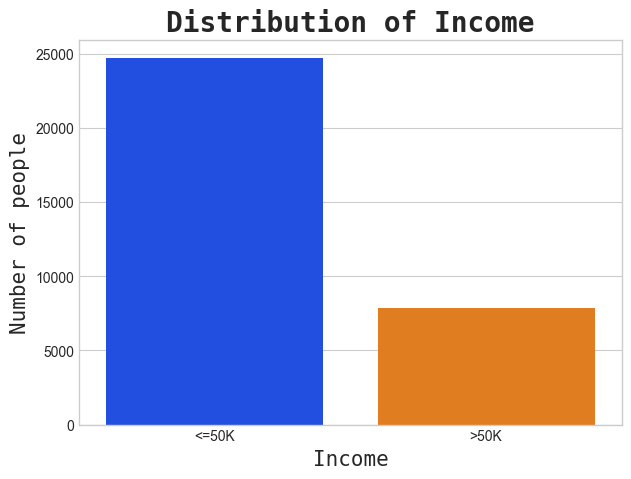

In [20]:
# Creating a barplot for 'Income'
income = df["income"].value_counts()

plt.style.use(style="seaborn-v0_8-whitegrid")
plt.figure(figsize=(7, 5))
sns.barplot(x=income.index, y=income.values, palette="bright")
plt.title(
    "Distribution of Income",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Income", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=10)

plt.show()

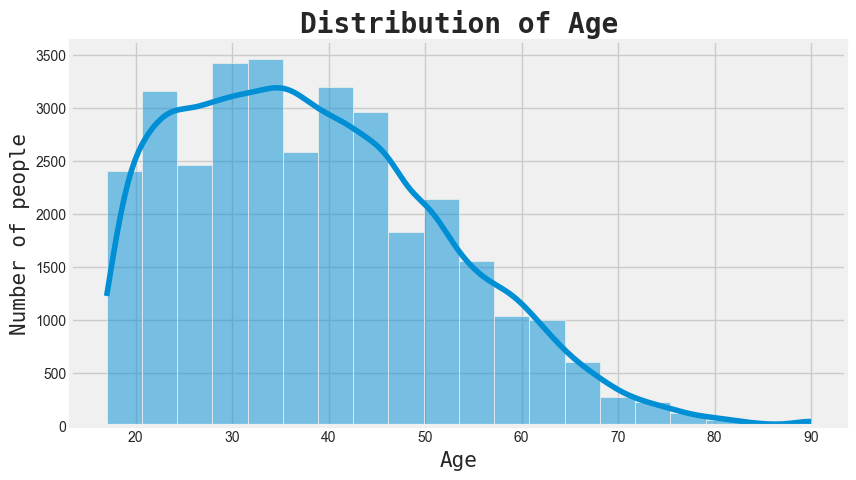

In [21]:
# Creating a distribution plot for 'Age'
age = df["age"].value_counts()

plt.figure(figsize=(10, 5))
plt.style.use("fivethirtyeight")
sns.histplot(df["age"], bins=20, kde=True)
plt.title(
    "Distribution of Age",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Age", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=10)
plt.show()

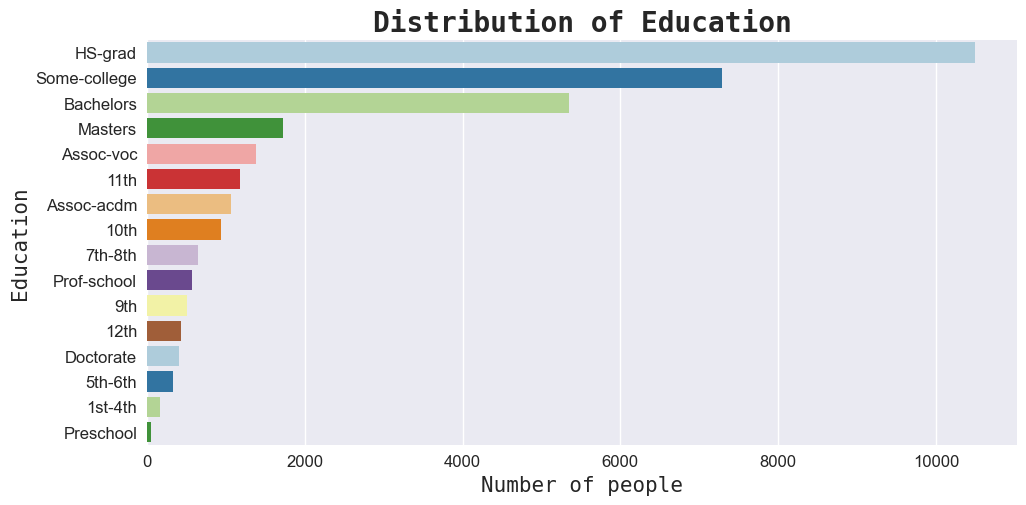

In [22]:
# Creating a barplot for 'Education'
edu = df["education"].value_counts()

plt.style.use("seaborn-v0_8")
plt.figure(figsize=(10, 5))
sns.barplot(x=edu.values, y=edu.index, palette="Paired")
plt.title(
    "Distribution of Education",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Education", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.show()

[2024-02-05 17:53:13,782]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-05 17:53:13,792]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


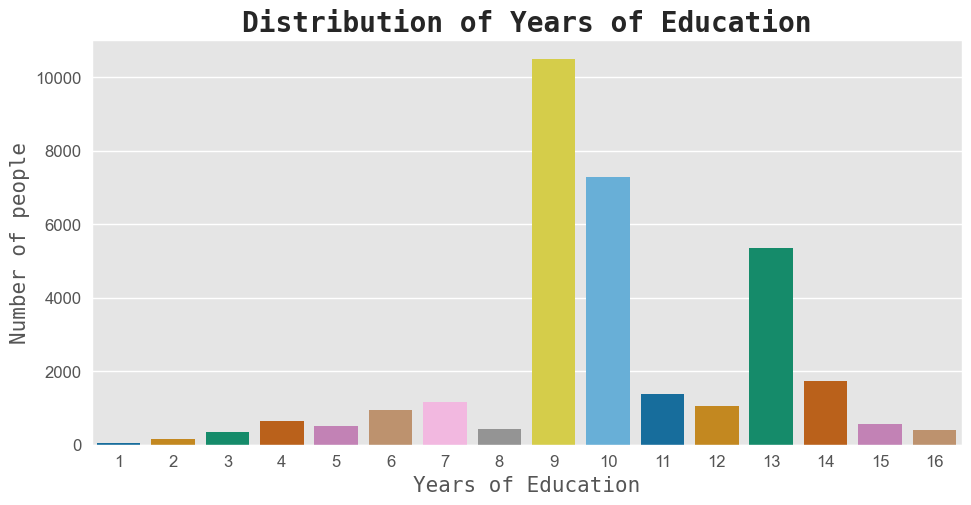

In [23]:
# Creating a barplot for 'Years of Education'
edu_num = df["education.num"].value_counts()

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
sns.barplot(x=edu_num.index, y=edu_num.values, palette="colorblind")
plt.title(
    "Distribution of Years of Education",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Years of Education", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.show()

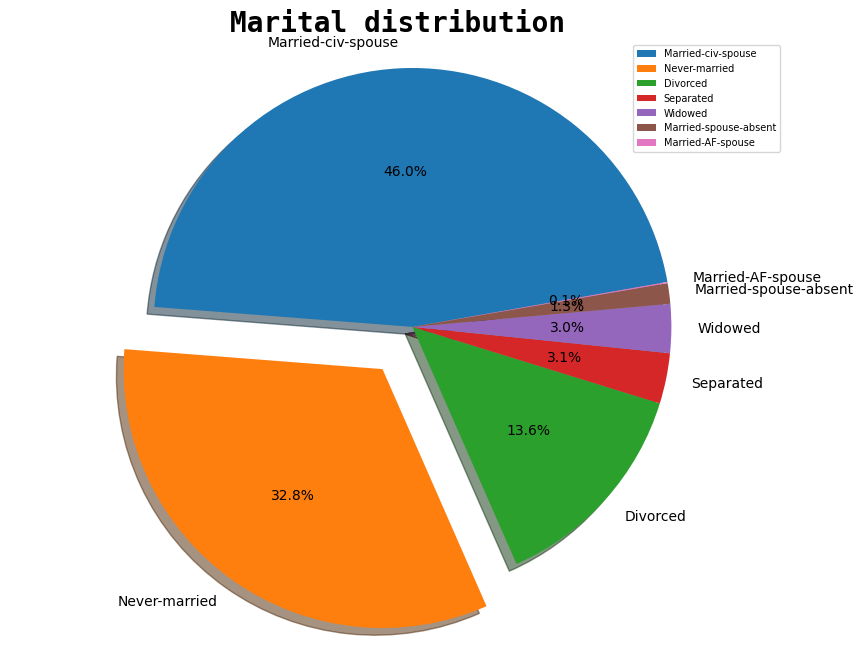

In [24]:
# Creating a pie chart for 'Marital status'
marital = df["marital.status"].value_counts()

plt.style.use("default")
plt.figure(figsize=(10, 8))
plt.pie(
    marital.values,
    labels=marital.index,
    startangle=10,
    explode=(0, 0.20, 0, 0, 0, 0, 0),
    shadow=True,
    autopct="%1.1f%%",
)
plt.title(
    "Marital distribution",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.legend()
plt.legend(prop={"size": 7})
plt.axis("equal")
plt.show()

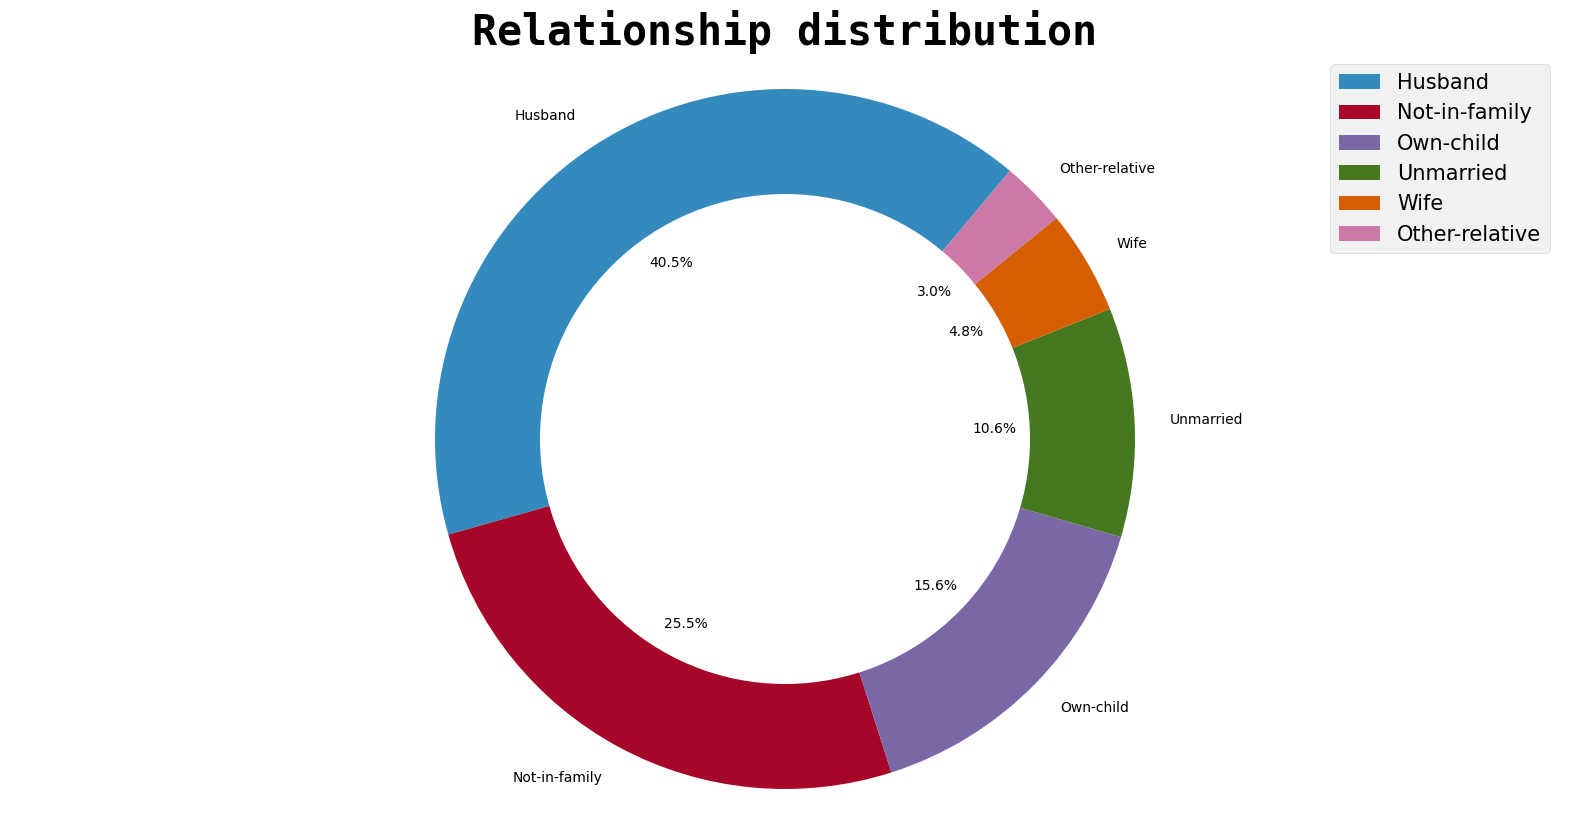

In [25]:
# Creating a donut chart for 'Age'
relation = df["relationship"].value_counts()

plt.style.use("bmh")
plt.figure(figsize=(20, 10))
plt.pie(relation.values, labels=relation.index, startangle=50, autopct="%1.1f%%")
centre_circle = plt.Circle((0, 0), 0.7, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title(
    "Relationship distribution",
    fontdict={"fontname": "Monospace", "fontsize": 30, "fontweight": "bold"},
)
plt.axis("equal")
plt.legend(prop={"size": 15})
plt.show()

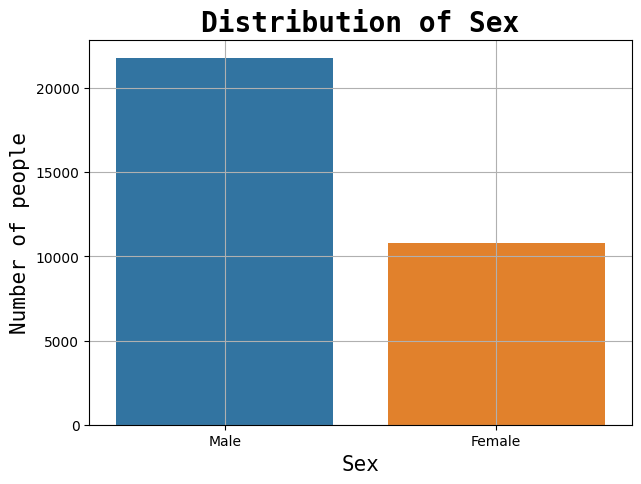

In [26]:
# Creating a barplot for 'Sex'
sex = df["sex"].value_counts()

plt.style.use("default")
plt.figure(figsize=(7, 5))
sns.barplot(x=sex.index, y=sex.values, hue=sex.index)
plt.title(
    "Distribution of Sex",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Sex", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=10)
plt.grid()
plt.show()

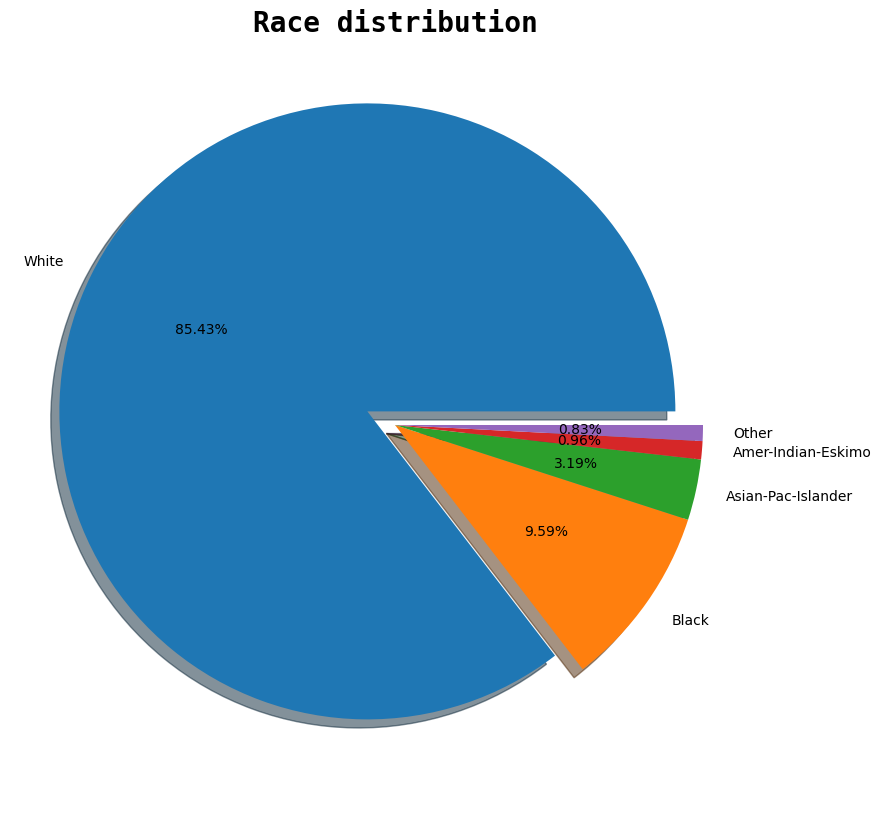

In [27]:
# Creating a Treemap for 'Race'
race = df["race"].value_counts()

plt.style.use("default")
plt.figure(figsize=(12, 10))
plt.pie(
    race.values,
    labels=race.index,
    explode=[0.1, 0, 0, 0, 0],
    shadow=True,
    autopct="%0.2f%%",
)
plt.title(
    "Race distribution",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.show()

[2024-02-05 17:53:14,872]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-05 17:53:14,879]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


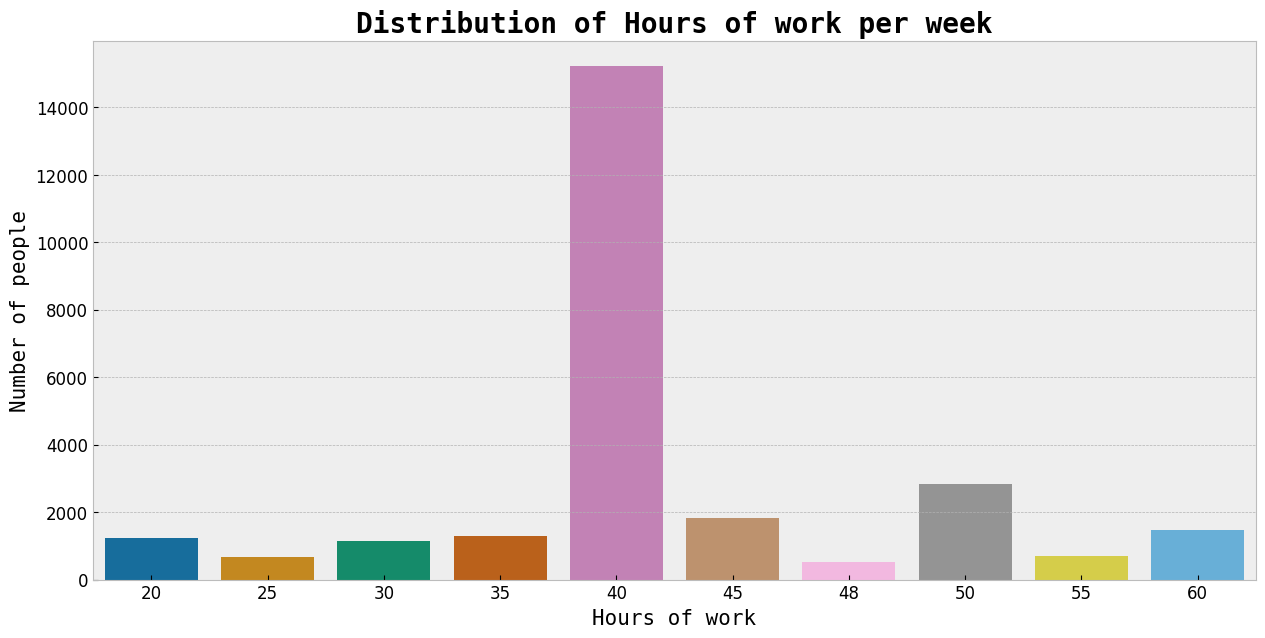

In [28]:
# Creating a barplot for 'Hours per week'
hours = df["hours.per.week"].value_counts().head(10)

plt.style.use("bmh")
plt.figure(figsize=(15, 7))
sns.barplot(x=hours.index, y=hours.values, palette="colorblind")
plt.title(
    "Distribution of Hours of work per week",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Hours of work", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.show()

[2024-02-05 17:53:15,225]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-05 17:53:15,250]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


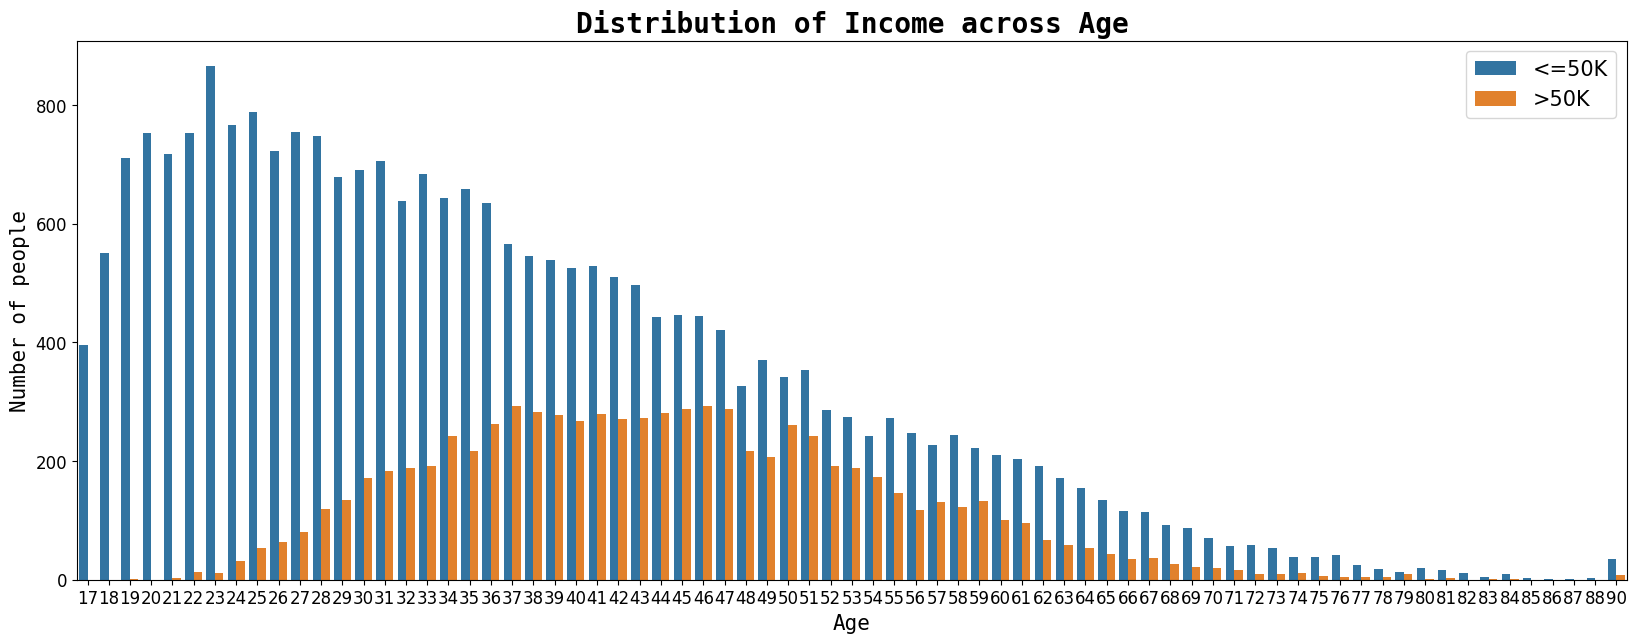

In [29]:
# Creating a countplot of income across age
plt.style.use("default")
plt.figure(figsize=(20, 7))
sns.countplot(x=df["age"], hue=df["income"])
plt.title(
    "Distribution of Income across Age",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Age", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={"size": 15})
plt.show()

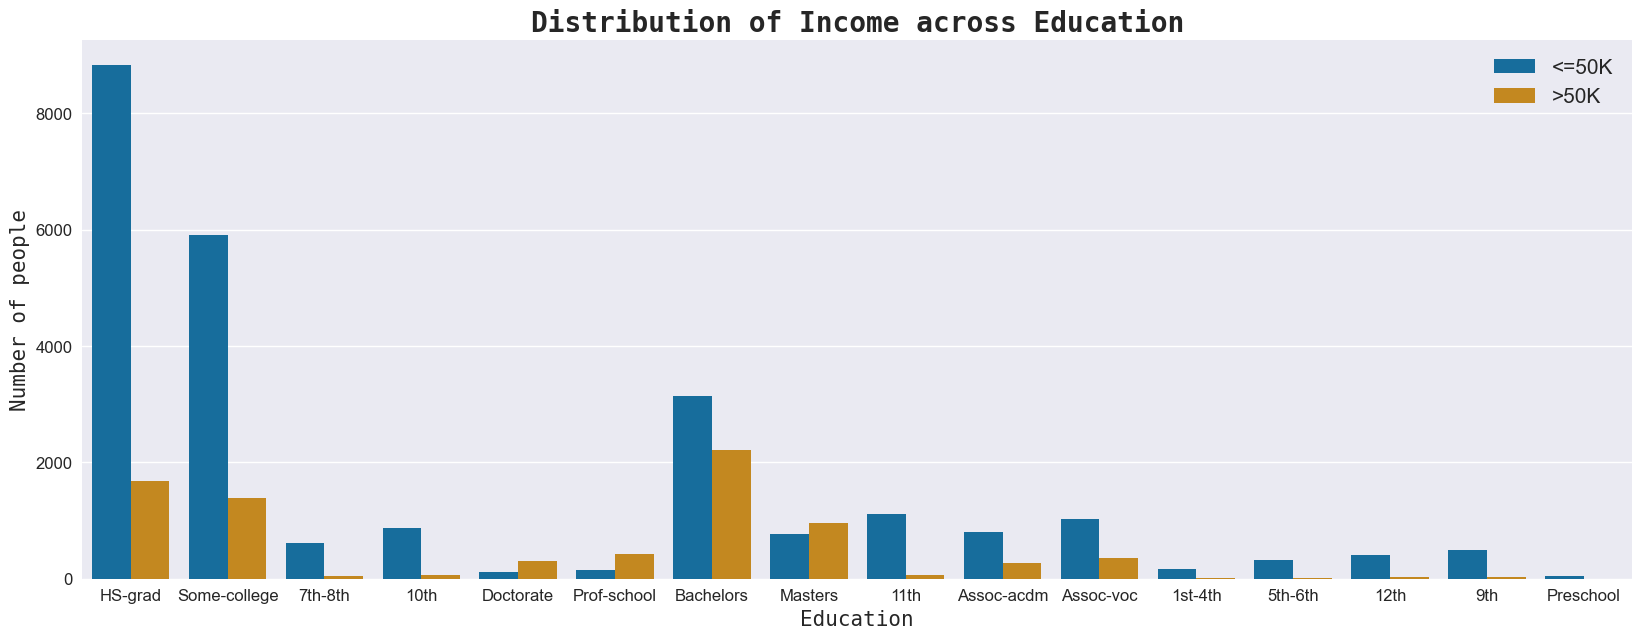

In [30]:
# Creating a countplot of income across education
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(20, 7))
sns.countplot(x=df["education"], hue=df["income"], palette="colorblind")
plt.title(
    "Distribution of Income across Education",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Education", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={"size": 15})
plt.show()

[2024-02-05 17:53:16,129]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-05 17:53:16,154]: INFO category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


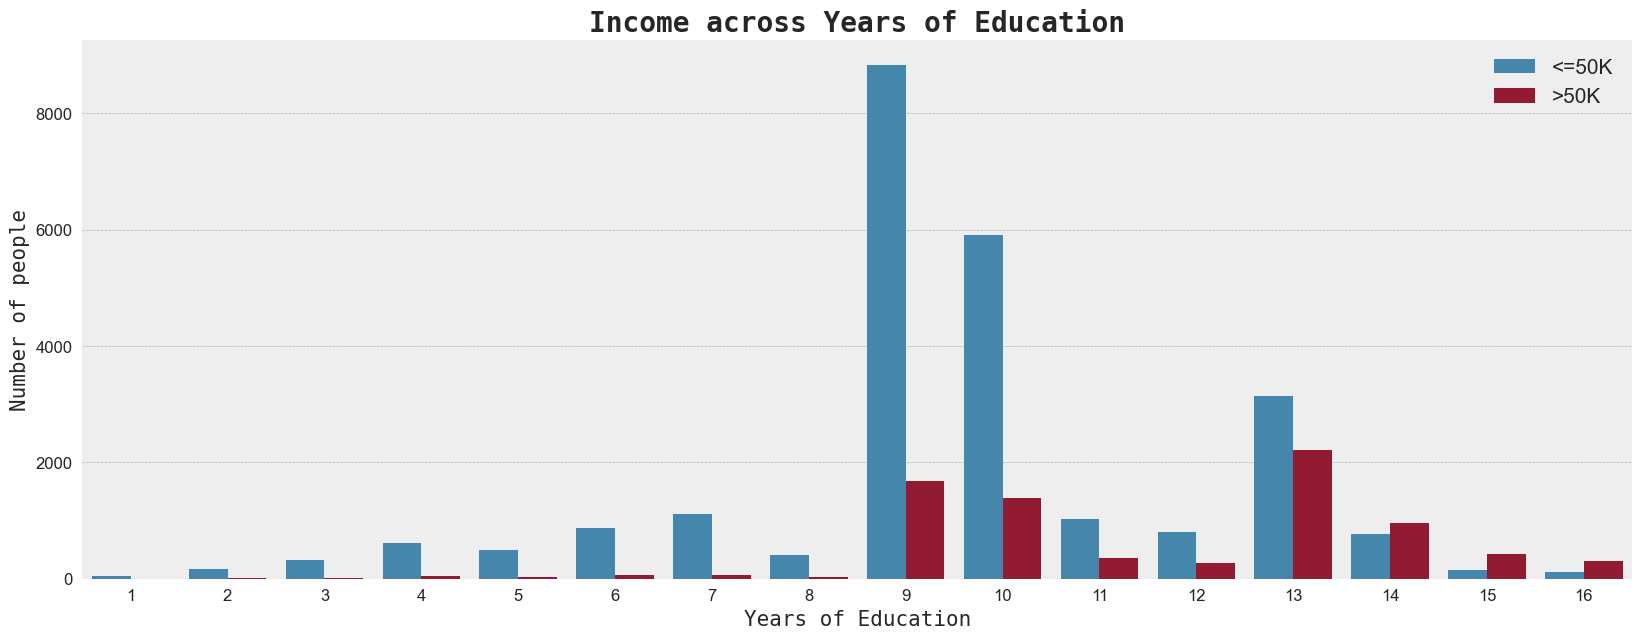

In [31]:
# Creating a countplot of income across years of education
plt.style.use("bmh")
plt.figure(figsize=(20, 7))
sns.countplot(x=df["education.num"], hue=df["income"])
plt.title(
    "Income across Years of Education",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Years of Education", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={"size": 15})
plt.show()

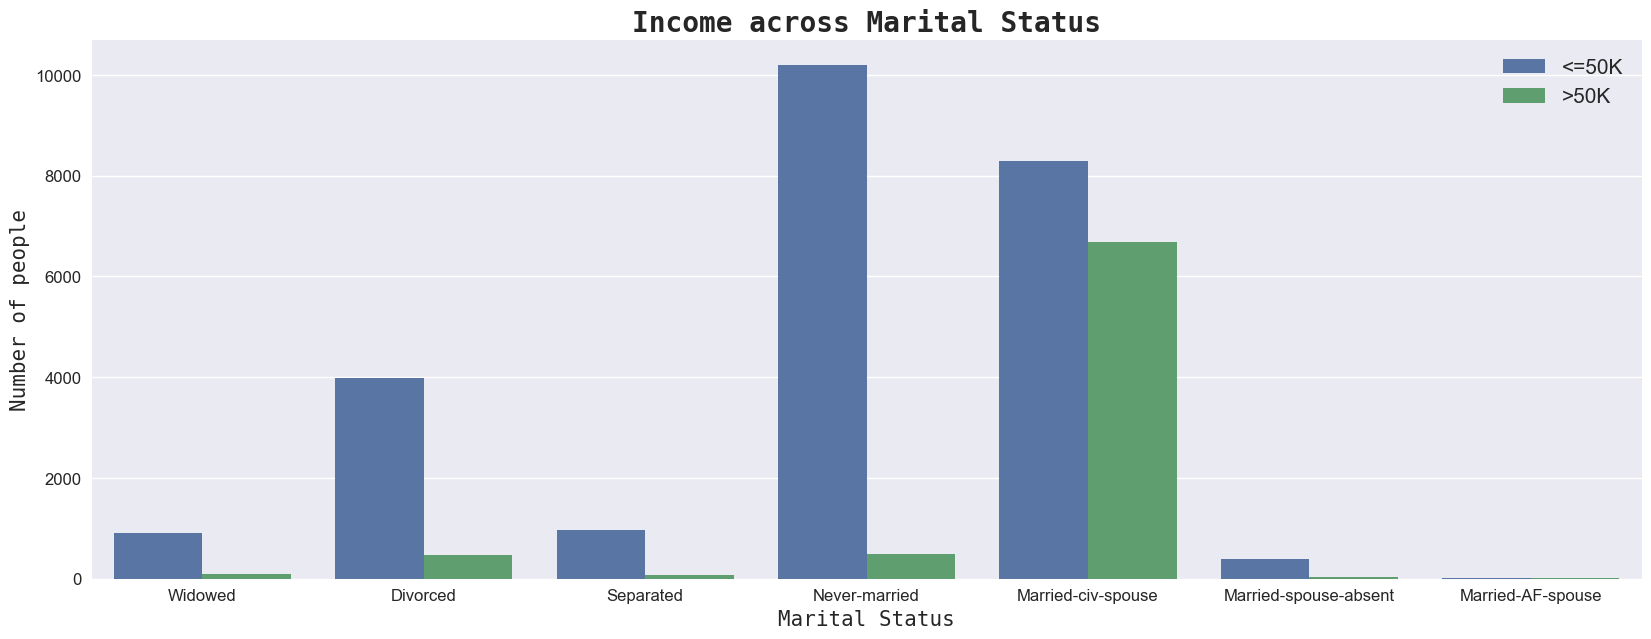

In [32]:
# Creating a countplot of income across Marital Status
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(20, 7))
sns.countplot(x=df["marital.status"], hue=df["income"])
plt.title(
    "Income across Marital Status",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Marital Status", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={"size": 15})
plt.show()

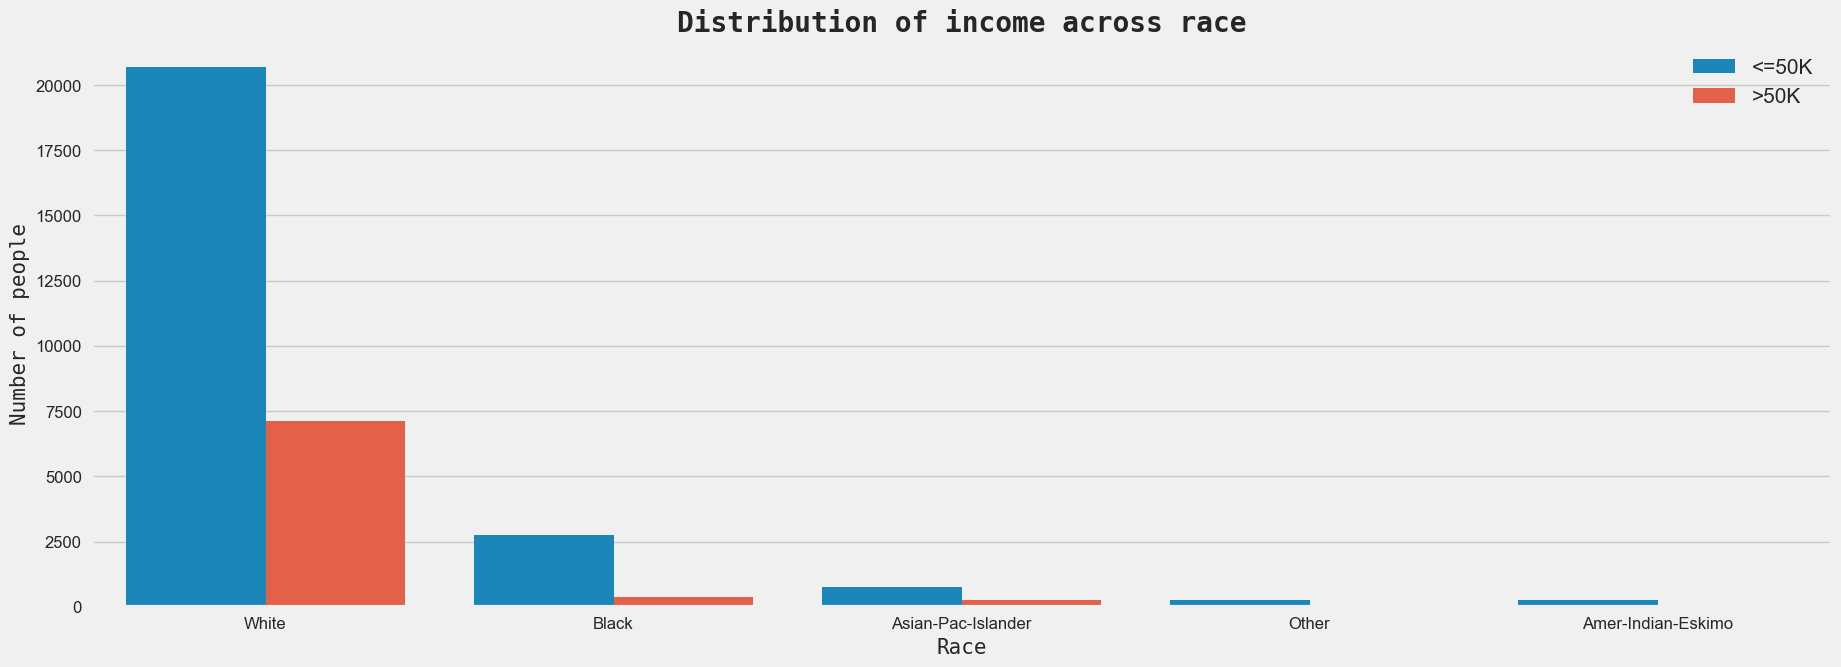

In [33]:
# Creating a countplot of income across race
plt.style.use("fivethirtyeight")
plt.figure(figsize=(20, 7))
sns.countplot(x=df["race"], hue=df["income"])
plt.title(
    "Distribution of income across race",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Race", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={"size": 15})
plt.show()

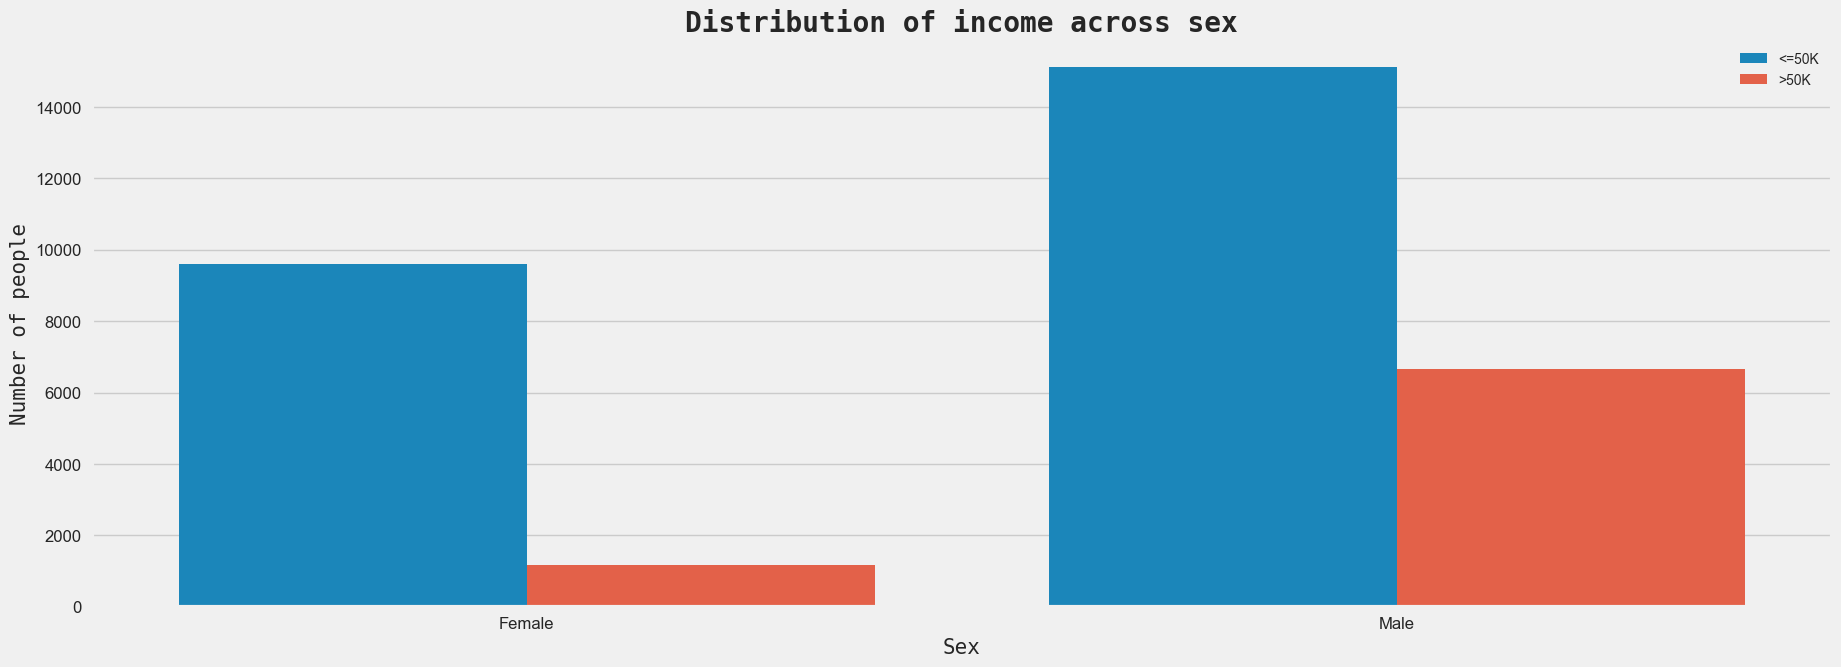

In [34]:
# Creating a countplot of income across sex
plt.style.use("fivethirtyeight")
plt.figure(figsize=(20, 7))
sns.countplot(x=df["sex"], hue=df["income"])
plt.title(
    "Distribution of income across sex",
    fontdict={"fontname": "Monospace", "fontsize": 20, "fontweight": "bold"},
)
plt.xlabel("Sex", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.ylabel("Number of people", fontdict={"fontname": "Monospace", "fontsize": 15})
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={"size": 10})
plt.show()

#### 4.2 Multivariate Analysis


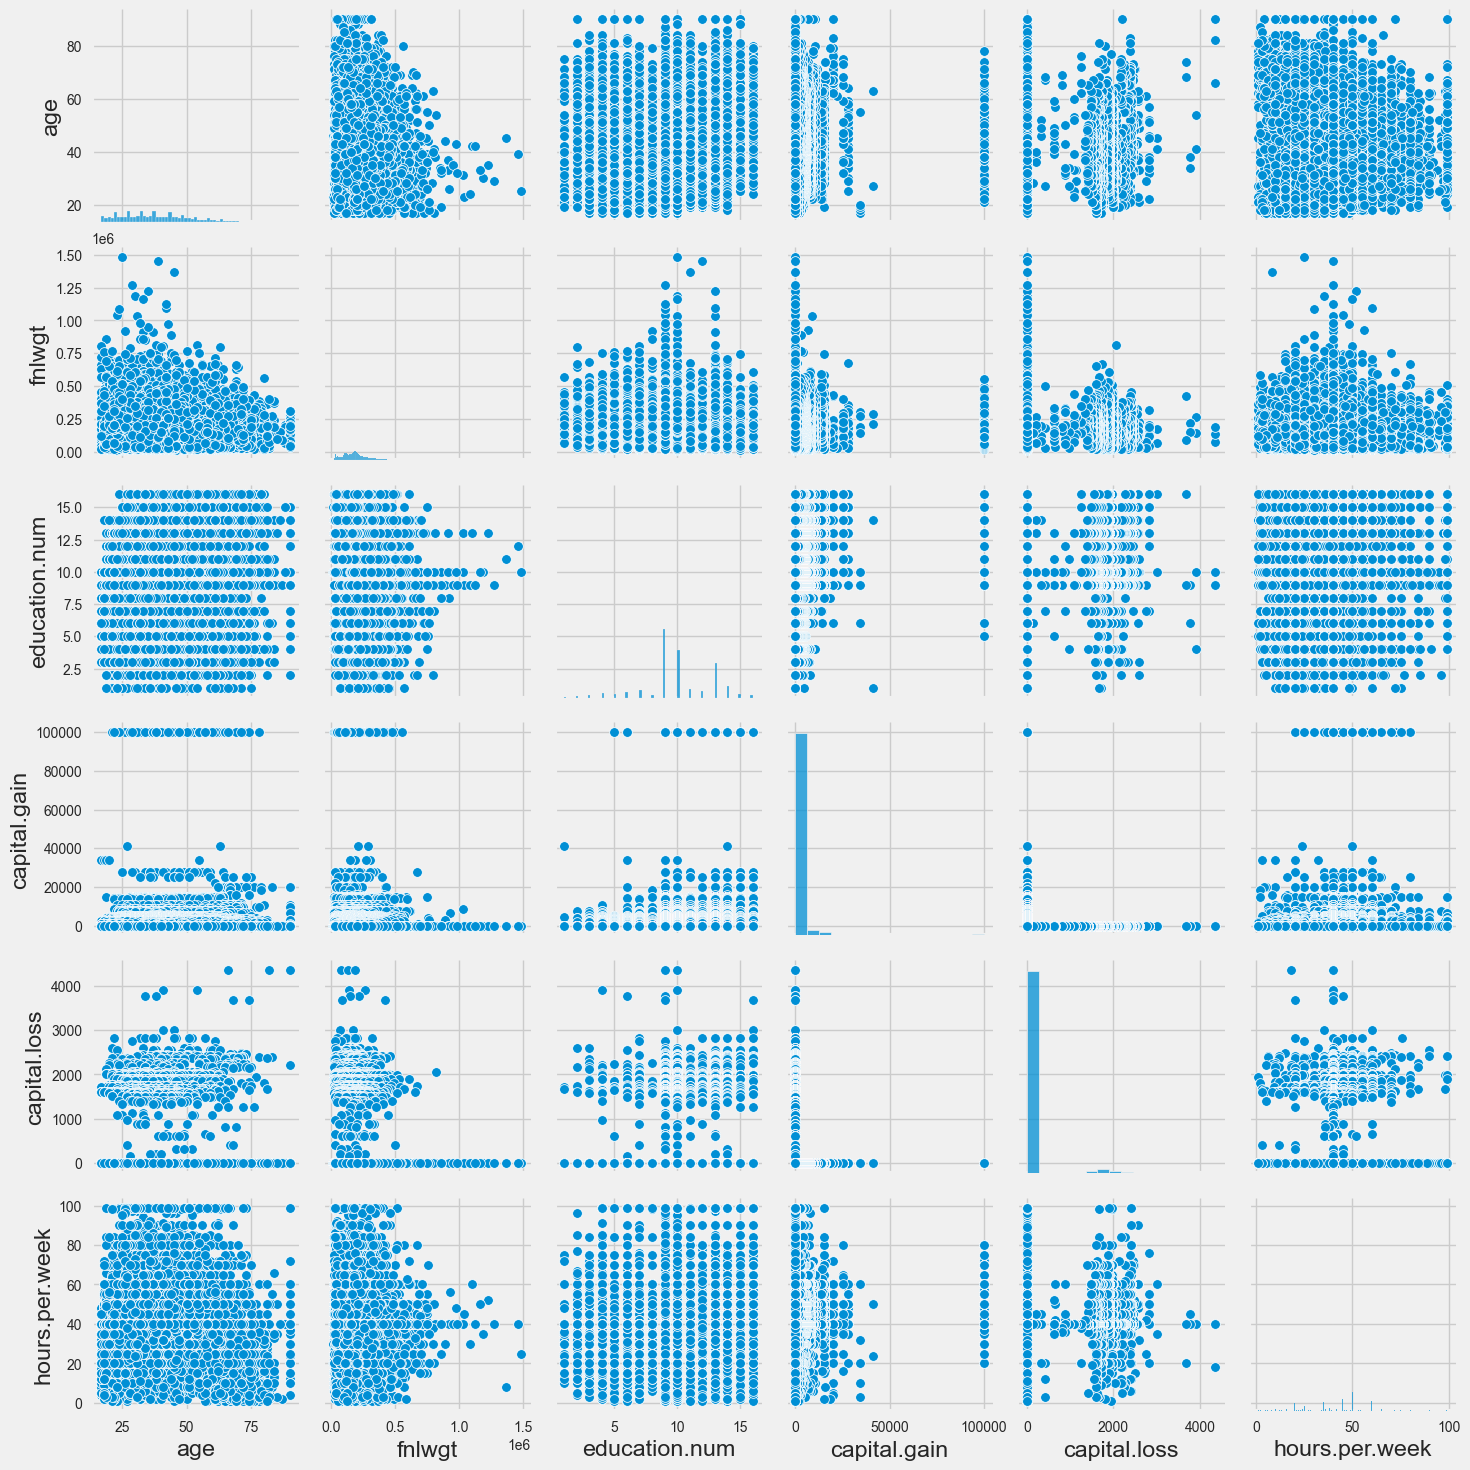

In [35]:
sns.pairplot(df)
plt.show()

In [36]:
cate_col = df.select_dtypes(include="object").columns
num_col = df.select_dtypes(exclude="object").columns
cate_col, num_col

(Index(['workclass', 'education', 'marital.status', 'occupation',
        'relationship', 'race', 'sex', 'native.country', 'income'],
       dtype='object'),
 Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
        'hours.per.week'],
       dtype='object'))

In [37]:
df1 = df.copy()

In [38]:
df[cate_col] = df[cate_col].apply(LabelEncoder().fit_transform)

In [39]:
df1.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


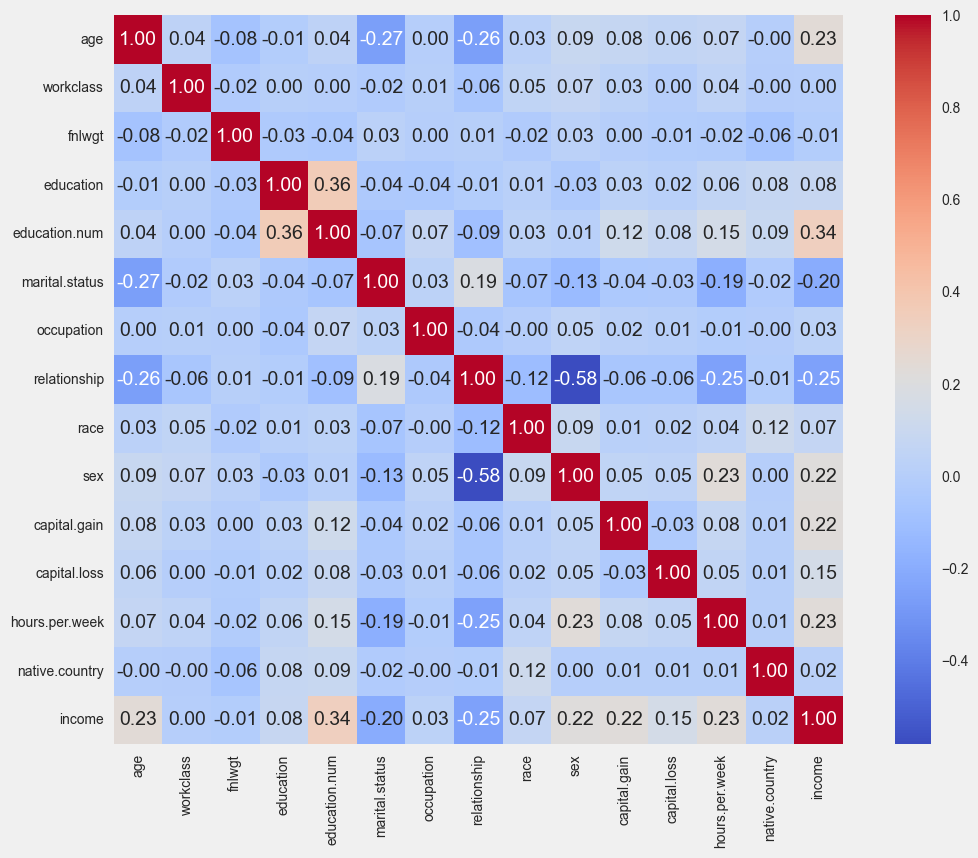

In [40]:
corr = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(data=corr, annot=True, fmt="0.2f", cmap="coolwarm", square=True)
plt.show()

<div class="alert alert-block alert-info">

### Observations:

- In this dataset, the most number of people are young, white, male, high school graduates with 9 to 10 years of education and work 40 hours per week.

- From the correlation heatmap, we can see that the dependent feature 'income' is highly correlated with age, numbers of years of education, capital gain and number of hours per week.

<div>


### 4.3 Feature Selection


In [41]:
X = df.drop("income", axis=1)
y = df['income']

In [42]:
feat_imp = pd.DataFrame()
rf = RandomForestClassifier()
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X, y)
rf.fit(X, y)
feat_imp["Feature"] = X.columns
feat_imp["Imp"] = rfe.support_
feat_imp["Score"] = np.round(rf.feature_importances_, 2)
feat_imp.sort_values("Score", ascending=False)

,Feature,Imp,Score
2,fnlwgt,True,0.17
0,age,True,0.15
10,capital.gain,True,0.12
7,relationship,True,0.11
4,education.num,True,0.09
12,hours.per.week,True,0.08
5,marital.status,True,0.06
6,occupation,True,0.06
1,workclass,True,0.04
11,capital.loss,True,0.04


In [43]:
X = X.drop(feat_imp[(feat_imp["Score"] < 0.05)]["Feature"], axis=1)
X.head()

,age,fnlwgt,education.num,marital.status,occupation,relationship,capital.gain,hours.per.week
0,90,77053,9,6,9,1,0,40
1,82,132870,9,6,3,1,0,18
2,66,186061,10,6,9,4,0,40
3,54,140359,4,0,6,4,0,40
4,41,264663,10,5,9,3,0,40


In [44]:
cate_col = [col for col in cate_col if col in X.columns]
cate_col.remove("relationship")
num_col = [col for col in num_col if col in X.columns]
[num_col.remove(col) for col in ["fnlwgt", "capital.gain"]]
cate_col, num_col

(['marital.status', 'occupation', 'relationship'],
 ['age', 'education.num', 'hours.per.week'])

In [49]:
df1["occupation"].unique()

array(['Prof-specialty', 'Exec-managerial', 'Machine-op-inspct',
       'Other-service', 'Adm-clerical', 'Craft-repair',
       'Transport-moving', 'Handlers-cleaners', 'Sales',
       'Farming-fishing', 'Tech-support', 'Protective-serv',
       'Armed-Forces', 'Priv-house-serv'], dtype=object)

In [51]:
df1["marital.status"].unique()

array(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [45]:
cate_pipe = Pipeline(
    [
        ("OneHotEncoder", OneHotEncoder())
    ]
)

num_pipe = Pipeline(
    [
        ("StandardScaler", StandardScaler())
    ]
)

In [46]:
preprocessor = ColumnTransformer(
    [
        ("num_pipe", num_pipe, num_col),
        ("cate_pipe", cate_pipe, cate_col)
    ]
)

In [47]:
df1 = df1[num_col + cate_col + ["income"]]
df1.head()

,age,education.num,hours.per.week,marital.status,occupation,relationship,income
0,90,9,40,Widowed,Prof-specialty,Not-in-family,<=50K
1,82,9,18,Widowed,Exec-managerial,Not-in-family,<=50K
2,66,10,40,Widowed,Prof-specialty,Unmarried,<=50K
3,54,4,40,Divorced,Machine-op-inspct,Unmarried,<=50K
4,41,10,40,Separated,Prof-specialty,Own-child,<=50K


In [48]:
X = df1.drop("income", axis=1)
preprocessed_data = preprocessor.fit_transform(X)
preprocessed_data = pd.DataFrame(preprocessed_data.toarray(), columns=preprocessor.get_feature_names_out())
preprocessed_data["income"] = y.values
preprocessed_data.head()

,num_pipe__age,num_pipe__education.num,num_pipe__hours.per.week,cate_pipe__marital.status_Divorced,cate_pipe__marital.status_Married-AF-spouse,cate_pipe__marital.status_Married-civ-spouse,cate_pipe__marital.status_Married-spouse-absent,cate_pipe__marital.status_Never-married,cate_pipe__marital.status_Separated,cate_pipe__marital.status_Widowed,...,cate_pipe__occupation_Sales,cate_pipe__occupation_Tech-support,cate_pipe__occupation_Transport-moving,cate_pipe__relationship_Husband,cate_pipe__relationship_Not-in-family,cate_pipe__relationship_Other-relative,cate_pipe__relationship_Own-child,cate_pipe__relationship_Unmarried,cate_pipe__relationship_Wife,income
0,3.769612,-0.420060,-0.035429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,3.183112,-0.420060,-1.817204,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,2.010110,-0.031360,-0.035429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,1.130359,-2.363558,-0.035429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.177296,-0.031360,-0.035429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
